In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from extinctions import *
from preprocessing import *

In [3]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
scatter_simple = (band_centers/500)**(-1.3)

absorption for 80% water, 10% lipids, 50microMol hemoglobin, 2micloMol cytochrome

(520.0, 900.0)

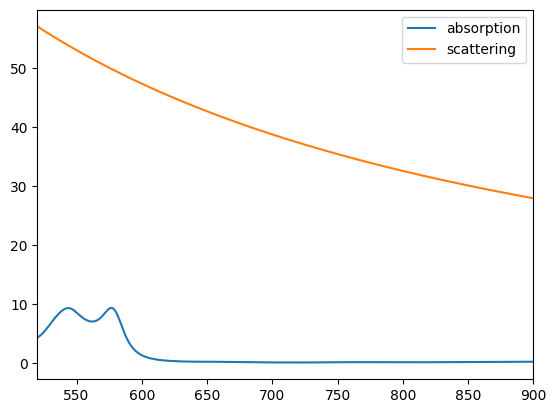

In [10]:
mu_a = 0.8*water + 0.1*fat + (25*hb + 25*hbo2 + 1*cyt_c_ox + 1*cyt_c_red + 1*cyt_b_ox + 1*cyt_b_red + 1*cyt_oxi_ox + 1*cyt_oxi_red)/1000
mu_s = 60*scatter_simple

name = "hbo2_50"

plt.plot(band_centers, mu_a, label="absorption")
plt.plot(band_centers, mu_s, label="scattering")
plt.legend()
plt.xlim(bands_range)

### Generate input file following .mci format:

1.0                         # file version<br>
1                        	# number of runs<br>

\### RUN for ... nm<br>
sample.mco 	A	      		# output file name, ASCII.<br>
100000                  	# No. of photons<br>
100000000	1               # dz, dr [cm]<br>
1	1	1                	# No. of dz, dr, da.<br>
1                        	# Number of layers<br>
#n mua mus	g	d         	# One line for each layer<br>
1                         	# n for medium above<br>
1.4	0.1	90	0.9	100000000	# layer 1<br>
1                        	# n for medium below<br>

...

In [18]:
def setup_mci_files(name, band_centers, mu_a, mu_s):
    n_photons = 1000000
    dz, dr = 100000000, 1
    g = 0.9
    d = 1e8

    output_folder = f"output_{name}"
    os.makedirs(output_folder, exist_ok=True)
    # create new .mci file
    f = open(f"input_{name}.mci", "w")
    f.write("1.0    # file version\n")
    f.write(f"{band_centers.shape[0]}    # number of runs\n")

    for i in range(band_centers.shape[0]):
        f.write("\n")
        f.write(f"### RUN for {band_centers[i]} nm\n")
        output_file = os.path.join(output_folder,f"{band_centers[i]}.mco")
        f.write(f"{output_file}  A    # output file\n")
        f.write(f"{n_photons}    # No. of photons\n")
        f.write(f"{dz}  {dr}    # dz, dr\n")
        f.write(f"1  1  1    # No. of dz, dr, da\n")
        f.write(f"1    # Number of layers\n")
        f.write(f"#n  mu_a  mu_s  g  d\n")
        f.write(f"1    # n for medium above\n")
        f.write(f"1.4  {mu_a[i]}  {mu_s[i]}  {g}  {int(d)}\n")
        f.write(f"1    # n for medium below\n")
    f.close()

setup_mci_files(name, band_centers, mu_a, mu_s)

### Run MC simulation

In [12]:
os.system(f"./CUDAMCML input_{name}.mci -A > /dev/null");

### Read reflectance data from output files and save it as .txt

In [17]:
def read_mco_files(name, band_centers):
    output_folder = f"output_{name}"
    R_spec = np.zeros(band_centers.shape[0])
    R_diffuse = np.zeros(band_centers.shape[0])
    for i in range(band_centers.shape[0]):
        output_file = os.path.join(output_folder,f"{band_centers[i]}.mco")
        f = open(output_file, "r")
        for line in f:
            # if "Specular reflectance" in line:
            #     R_spec[i] = float(line.split()[0])
            if "Diffuse reflectance" in line:
                R_diffuse[i] = float(line.split()[0])
        f.close()
    
    # clean up output folder and input file
    os.system(f"rm -rf {output_folder}")
    os.system(f"rm input_{name}.mci")

    return R_diffuse
    
R_diffuse = read_mco_files(name, band_centers)

# save R_diff as text file
np.savetxt(os.path.join("spectra_mc", f"R_{name}.txt"), R_diffuse)

# plot simulation results
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True)
# plt.plot(band_centers, R_spec, label="R_spec")
axs[0].plot(band_centers, R_diffuse, label="R_diffuse")
axs[0].set_xlim(bands_range)
axs[0].set_title("Diffuse reflectance")

absorbance = -np.log(R_diffuse)
axs[1].plot(band_centers, absorbance, label="absorbance")
# axs[1].set_xlim(bands_range)
axs[1].set_title("Absorbance")

### Compute endmember spectrum

In [43]:
def compute_endmember_spectrum(R, R_baseline):
    # R_baseline = np.loadtxt(os.path.join("spectra_mc", "R_baseline.txt"))
    # R = np.loadtxt(os.path.join("spectra_mc", f"R_{endmember_name}.txt"))

    R_baseline = smooth_spectral(R_baseline)
    R = smooth_spectral(R)

    A_baseline = -np.log(R_baseline)
    A = -np.log(R)
    m = A - A_baseline

    plt.figure()
    plt.plot(band_centers, A_baseline, label="R_baseline")
    plt.plot(band_centers, A, label="R")
    plt.plot(band_centers, m, label="$\Delta R$")

    return m

m = compute_endmember_spectrum(name)
np.savetxt(os.path.join("spectra_mc", f"m_{name}.txt"), m)

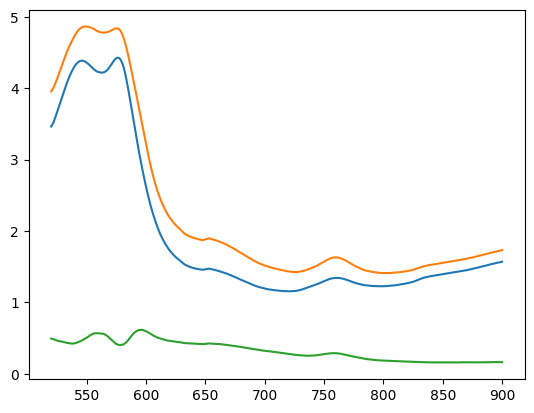

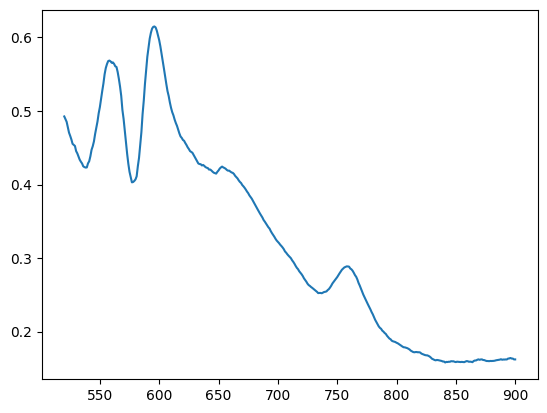

In [55]:
mu_a = 0.8*water + 0.1*fat + (50*hb + 25*hbo2 + 1*cyt_c_ox + 1*cyt_c_red + 1*cyt_b_ox + 1*cyt_b_red + 1*cyt_oxi_ox + 1*cyt_oxi_red)/1000
mu_s = 30*scatter_simple
name = "hhb_50_2"

setup_mci_files(name, band_centers, mu_a, mu_s)
os.system(f"./CUDAMCML input_{name}.mci -A > /dev/null")
R_diffuse = read_mco_files(name, band_centers)
np.savetxt(os.path.join("spectra_mc", f"R_{name}.txt"), R_diffuse)
R_baseline = np.loadtxt(os.path.join("spectra_mc", "R_baseline_2.txt"))
m = compute_endmember_spectrum(R_diffuse, R_baseline)
np.savetxt(os.path.join("spectra_mc", f"m_{name}.txt"), m)
plt.figure()
plt.plot(band_centers, m)